<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Multi_classification_1D_CNN_baseline_model_(%2Bquant).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CICIDS2017 Dataset

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
print(cicids2017_df['Attack Type'].value_counts())

# --- Label Encoding ---

# Get unique attack types
attack_types = cicids2017_df['Attack Type'].unique()

# Create a mapping from attack type to integer label
attack_type_map = {type: i for i, type in enumerate(attack_types)}

# Apply label encoding
cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].map(attack_type_map)

print("\nLabel Encoding Mapping:")
print(attack_type_map)


Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

Label Encoding Mapping:
{'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6}


# Train/val/test split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Train/val/test split ---
# Split label from datafram
X = cicids2017_df.drop('Attack Type', axis=1)
y = cicids2017_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify = y) # 80:20 training - test split
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify = y_temp)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


Visualisation of data split

Input Shapes -> Train: (1613280, 52), Val: (403320, 52), Test: (504151, 52)
Labels distribution -> Train: [1340836   58044    1371    5856   81929    1247  123997], Val: [335209  14511    343   1464  20482    312  30999], Test: [419012  18139    429   1830  25603    389  38749]


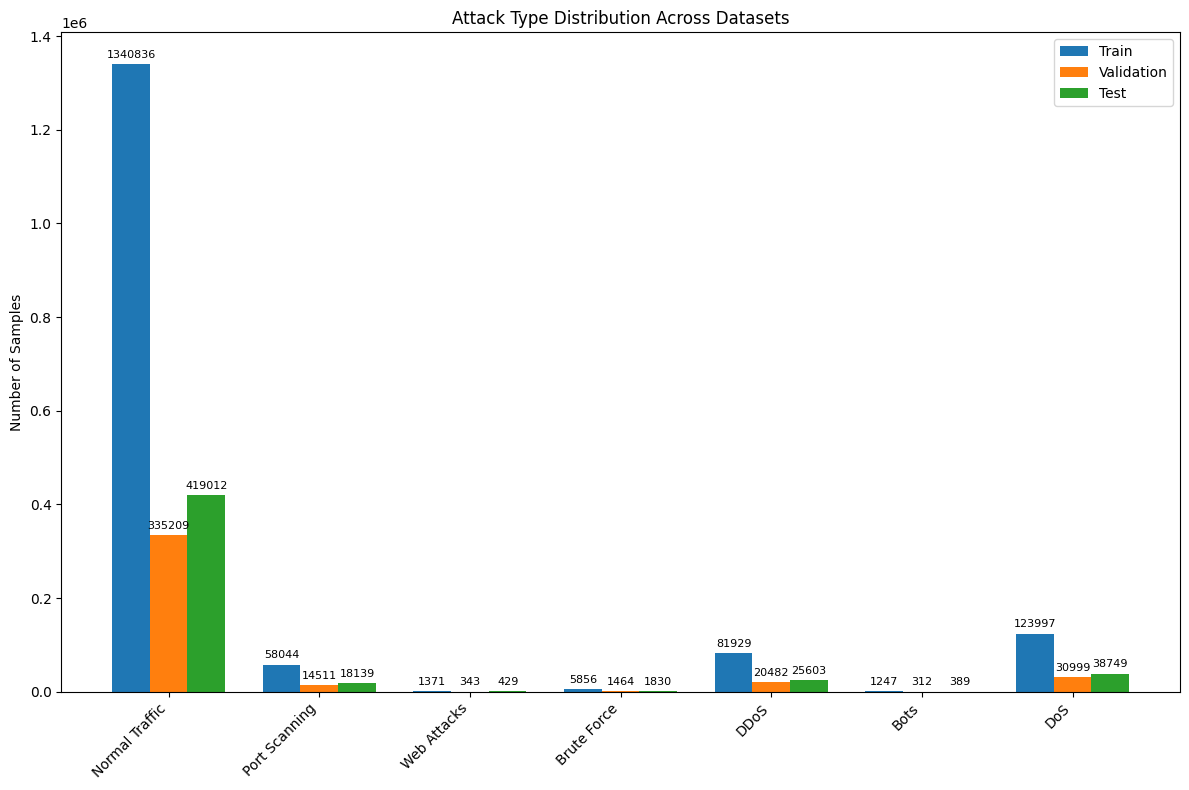

In [12]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Get the counts for each attack type in each dataset
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Get the number of unique attack types (based on the maximum index found)
num_attack_types = max(len(train_counts), len(val_counts), len(test_counts))

# Pad counts with zeros if some attack types are missing in a dataset split
train_counts = np.pad(train_counts, (0, num_attack_types - len(train_counts)), 'constant')
val_counts = np.pad(val_counts, (0, num_attack_types - len(val_counts)), 'constant')
test_counts = np.pad(test_counts, (0, num_attack_types - len(test_counts)), 'constant')


print(f"Labels distribution -> Train: {train_counts}, Val: {val_counts}, Test: {test_counts}")

# Data for plotting
datasets = ['Train', 'Validation', 'Test']
all_counts = np.array([train_counts, val_counts, test_counts])

# Get the original attack type names from the mapping
# Need to reverse the mapping to get names from labels
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(num_attack_types)]

x = np.arange(len(labels))  # the label locations for attack types
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8)) # Increase figure size

rects1 = ax.bar(x - width, all_counts[0], width, label='Train')
rects2 = ax.bar(x, all_counts[1], width, label='Validation')
rects3 = ax.bar(x + width, all_counts[2], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Attack Type Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right") # Rotate labels for better readability
ax.legend()

# Add value labels (optional, can make the plot cluttered with many categories)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.tight_layout()
plt.show()

#Normalise the datasets

In [13]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
#scaler = RobustScaler() # Initialize the scaler
scaler = StandardScaler() # Initialize the scaler

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")

Shape of X_train after scaling: (1613280, 52)
Shape of X_val after scaling: (403320, 52)
Shape of X_test after scaling: (504151, 52)


# Data reshaping for 1D CNN input

In [14]:
import numpy as np

# Reshape the data for 1D CNN input
# 1D CNN expects input shape: (samples, timesteps, features). timesteps = number of features, features = 1 (per timestep)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# --- Final Shape Confirmation ---
print("Training input shape:", X_train.shape)
print("Validation input shape:", X_val.shape)
print("Test input shape:", X_test.shape)

Training input shape: (1613280, 52, 1)
Validation input shape: (403320, 52, 1)
Test input shape: (504151, 52, 1)


# Perform Hyperparameter Tuning (Bayesian Optimisation) of 3 layer CNN model
Parameters tuned:


*   Conv1D: filters, kernel size
*   List item





In [ ]:
# Install tuner
!pip install keras-tuner --quiet

In [ ]:
# Setup
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [ ]:
def build_base_model(hp):
    model = Sequential()

    # First Conv1D block
    model.add(Conv1D(
        filters=hp.Choice('conv1_filters', values=[8, 16, 32, 64, 128]),
        kernel_size=hp.Choice('conv1_kernel_size', values=[2, 3, 5]), # was kernel_size=3,
        activation='relu',
        input_shape=(52, 1) # Define input shape here
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Choice('dropout1_rate', [0.0, 0.2, 0.25, 0.3, 0.5])))

    # Second Conv1D block
    model.add(Conv1D(
        filters=hp.Choice('conv2_filters', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv2_kernel_size', values=[2, 3, 5]), # was kernel_size=3,
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Choice('dropout2_rate', [0.0, 0.2, 0.25, 0.3, 0.5]))) #Changed to dropout2_rate

    # Third Conv1D block
    model.add(Conv1D(
        filters=hp.Choice('conv3_filters', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv3_kernel_size', values=[2, 3, 5]), # was kernel_size=3,
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    # Flatten previous layers
    model.add(Flatten())

    # Dense layer with L2 regularization
    model.add(Dense(
        hp.Choice('dense_units', [8, 12, 24, 64]),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('dense_L2', [0.0, 0.001, 0.0001, 0.01]))
    ))

    # Dropout layer
    model.add(Dropout(hp.Choice('dropout3_rate', [0.0, 0.2, 0.25, 0.3, 0.5])))

    # Dense layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.01])), #'adam', #add optimiser choices?
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = kt.BayesianOptimization(
    build_base_model,
    objective= 'val_accuracy',#kt.Objective('val_f1_score', direction='max'),# Find the hyperparameters that give the highest possible F1 score on the validation set    #'val_accuracy', #Change objective to get the lowest false negatives possible next?
    max_trials=10,
    directory='bayesian_tuning',
    project_name='baseline_cnn'
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss


tuner.search(X_train, y_train,
             epochs=10,
             batch_size=64,
             validation_data=(X_val, y_val),
             callbacks=[early_stop])

Trial 10 Complete [00h 12m 31s]
val_accuracy: 0.9758802056312561

Best val_accuracy So Far: 0.9848755598068237
Total elapsed time: 03h 01m 25s


# Display Best Hyperparameters

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
conv1_filters: 32
conv1_kernel_size: 3
dropout1_rate: 0.3
conv2_filters: 32
conv2_kernel_size: 3
dropout2_rate: 0.0
conv3_filters: 16
conv3_kernel_size: 5
dense_units: 24
dense_L2: 0.0
dropout3_rate: 0.3
learning_rate: 0.001


# Visualise Hyperparameter Tuning

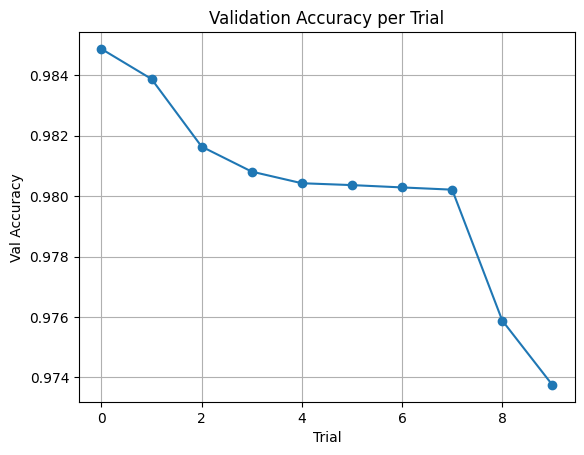

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

trials = tuner.oracle.get_best_trials(num_trials=20)
val_accuracies = [t.metrics.get_last_value('val_accuracy') for t in trials]

plt.plot(val_accuracies, marker='o')
plt.title('Validation Accuracy per Trial')
plt.xlabel('Trial')
plt.ylabel('Val Accuracy')
plt.grid(True)
plt.show()

# 3 layer 1D CNN multiclassification model

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# Best Hyperparameters from Bayesian Tuning
# conv1_filters: 32
# conv1_kernel_size: 3
# dropout1_rate: 0.3
# conv2_filters: 32
# conv2_kernel_size: 3
# dropout2_rate: 0.0
# conv3_filters: 16
# conv3_kernel_size: 5
# dense_units: 24
# dense_L2: 0.0
# dropout3_rate: 0.3
# learning_rate: 0.001

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)
num_classes = len(attack_type_map) # Get the number of unique attack types for the output layer


# Build model
model = Sequential([
    Input(shape=input_shape),

    Conv1D(filters=32, kernel_size=3, activation='relu'), # Detect patterns in the network traffic data
    BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
    Dropout(0.3), # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

    Conv1D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.0),

    Conv1D(filters=16, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0)), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
    Dropout(0.3), # Randomly drop 50% of the network's neurons to further prevent overfitting
    Dense(num_classes, activation='softmax')  # Final output layer for multiclass classification
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Use sparse_categorical_crossentropy for integer labels

#Train 1D CNN

- Major problems with class imbalance

Epoch 1/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 113s 4ms/step - accuracy: 0.9577 - loss: 0.1227 - val_accuracy: 0.9772 - val_loss: 0.0503
Epoch 2/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - accuracy: 0.9744 - loss: 0.0592 - val_accuracy: 0.9791 - val_loss: 0.0453
Epoch 3/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - accuracy: 0.9758 - loss: 0.0546 - val_accuracy: 0.9800 - val_loss: 0.0437
Epoch 4/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.9767 - loss: 0.0516 - val_accuracy: 0.9778 - val_loss: 0.0456
Epoch 5/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step - accuracy: 0.9769 - loss: 0.0502 - val_accuracy: 0.9798 - val_loss: 0.0420
Epoch 6/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.9779 - loss: 0.0486 - val_accuracy: 0.9824 - val_loss: 0.0399
Epoch 7/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step - accuracy: 0.9779 - loss: 0.0482 - val_accuracy: 0.9815 - val_loss: 0.0376
Epoch 8/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step - acc

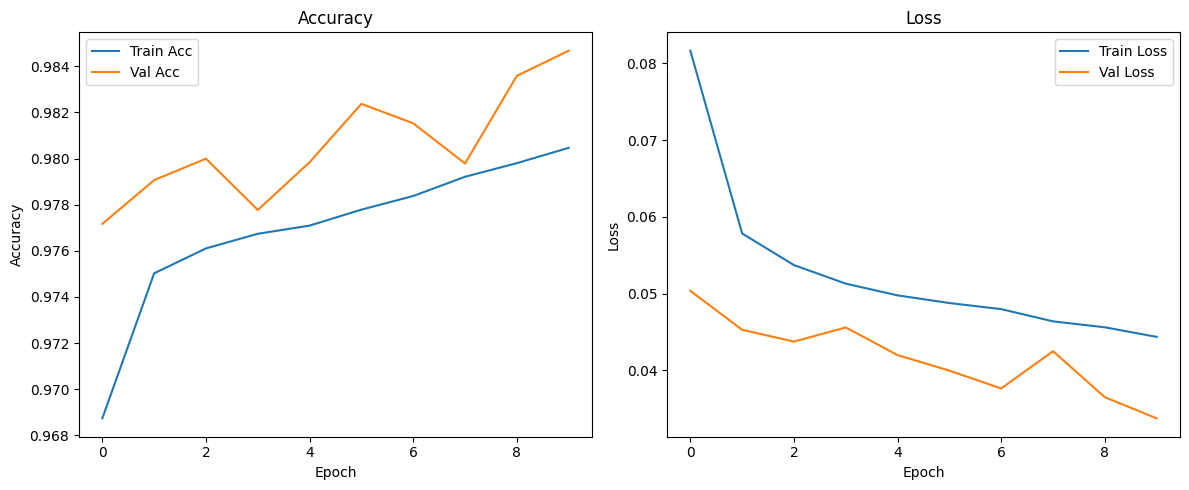

In [16]:
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping

# --- Early-stopping --- #TESTING
# https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e
# Early-stopping is a regularisation technique that prevents overfitting by stopping the training process when the model’s performance on the validation dataset starts degrading
# Stopping early reduces training time and computational costs

early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# Train the model with early stopping
start_time = timeit.default_timer()
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")


# Plot Accuracy and Loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

15755/15755 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step

Confusion Matrix:
[[416289   1567      0      4     41      6   1105]
 [  3277  14853      0      0      0      0      9]
 [   428      0      0      0      0      0      1]
 [    64      5      0   1753      0      0      8]
 [   403      0      0      0  25198      0      2]
 [   250      0      0      0      0    139      0]
 [   487      0      0      0      0      0  38262]]


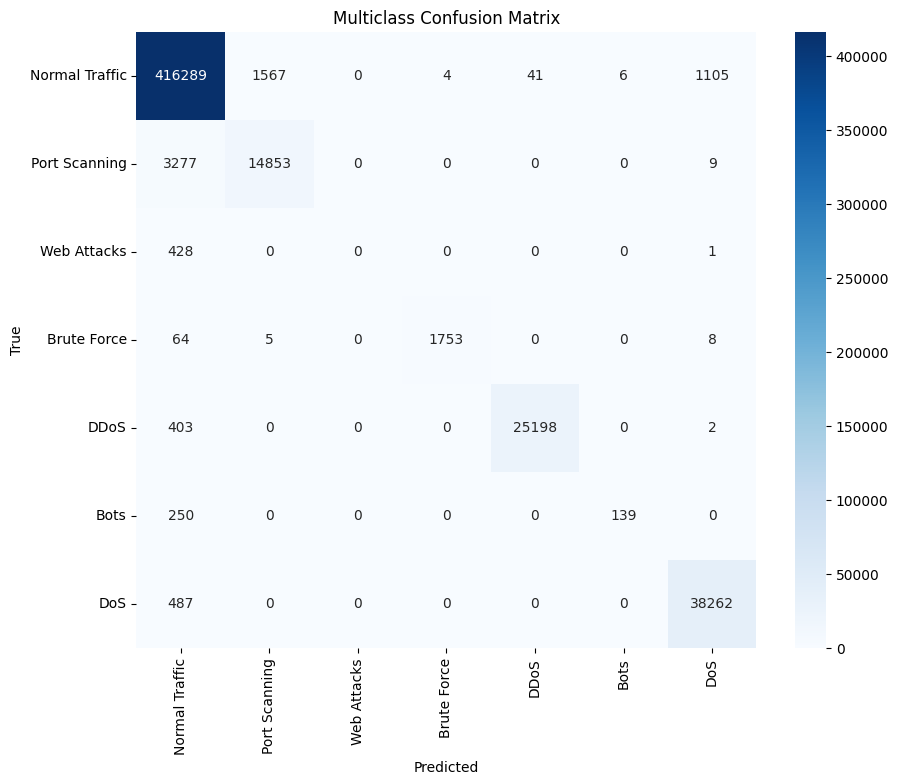


Accuracy:
sklearn Accuracy: 0.9848120900285827
model.evaluate Accuracy: 0.9848

Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.99      0.99      0.99    419012
 Port Scanning       0.90      0.82      0.86     18139
   Web Attacks       0.00      0.00      0.00       429
   Brute Force       1.00      0.96      0.98      1830
          DDoS       1.00      0.98      0.99     25603
          Bots       0.96      0.36      0.52       389
           DoS       0.97      0.99      0.98     38749

      accuracy                           0.98    504151
     macro avg       0.83      0.73      0.76    504151
  weighted avg       0.98      0.98      0.98    504151



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np # Import numpy

# Get predictions of x_test dataset
y_pred_probs = model.predict(X_test)

# For multiclass classification, the prediction is the class with the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
# For multiclass, confusion_matrix directly handles the true and predicted labels
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)

# Annotated heatmap (for multiclass, this can be large, consider if needed or use a smaller sample)
# Get the original attack type names from the mapping
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])] # Use matrix shape for label count


plt.figure(figsize=(10, 8)) # Adjust figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Accuracy scores
print("\nAccuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)# Evaluate model with test set
print(f"model.evaluate Accuracy: {test_acc:.4f}")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
# target_names should be the actual class names
print(classification_report(y_test, y_pred, target_names=labels))

#Plot of CNN's predictions vs. actual labels

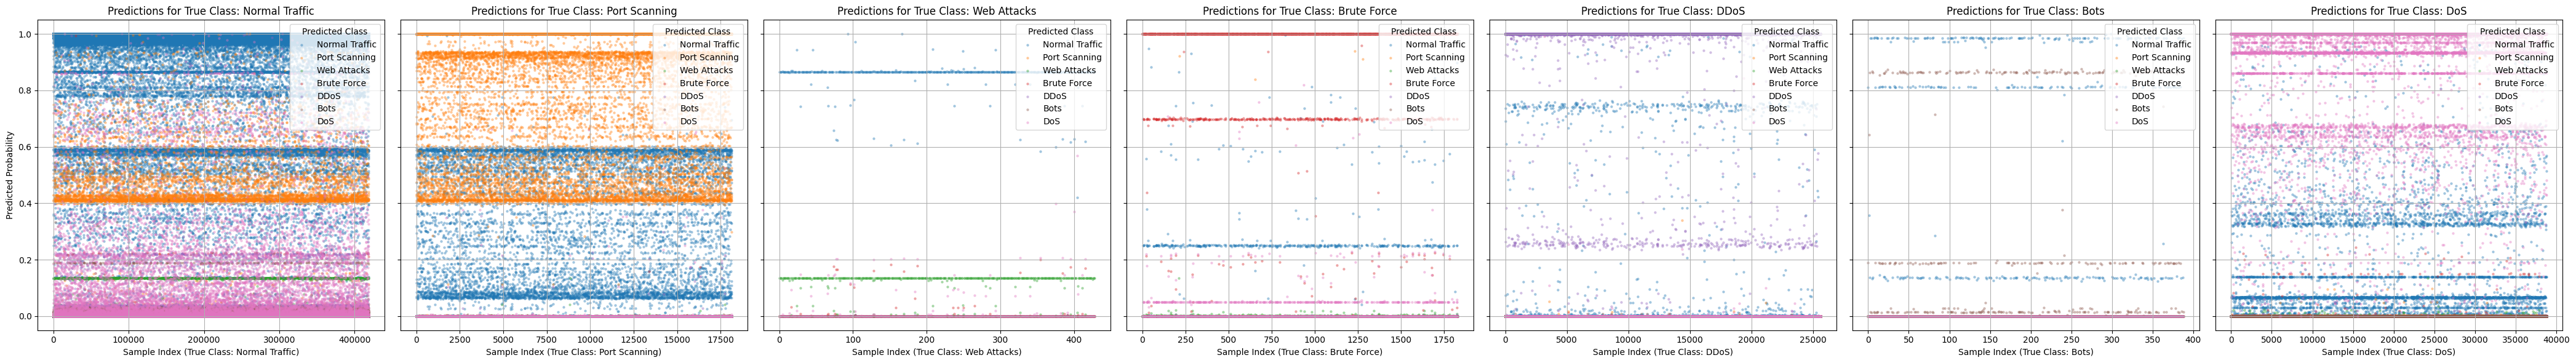

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming y_pred_probs and y_test are available from the previous evaluation step

# Get the unique attack types (true labels)
unique_true_labels = np.unique(y_test)
num_classes = y_pred_probs.shape[1]


# Get the original attack type names from the mapping
reverse_attack_type_mapping = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_mapping.get(i, f'Unknown {i}') for i in range(num_classes)]

# Create a figure with subplots for each true class
fig, axes = plt.subplots(nrows=1, ncols=len(unique_true_labels), figsize=(6 * len(unique_true_labels), 6), sharey=True)
axes = axes.flatten() # Flatten in case of a single row

for i, true_label in enumerate(unique_true_labels):
    # Get indices for the current true class
    indices = np.where(y_test == true_label)[0]
    if len(indices) == 0:
        axes[i].set_title(f'True Class: {labels[true_label]} (No samples)')
        continue

    # Get the predicted probabilities for these samples
    probs = y_pred_probs[indices]

    # Plot the predicted probability of each class for these samples
    for class_idx in range(num_classes):
        axes[i].scatter(np.arange(len(indices)), probs[:, class_idx], alpha=0.3, s=5, label=labels[class_idx])


    axes[i].set_ylim([-0.05, 1.05]) # Set y-axis limit for probabilities
    axes[i].set_xlabel(f"Sample Index (True Class: {labels[true_label]})")
    if i == 0:
        axes[i].set_ylabel("Predicted Probability")
    axes[i].set_title(f'Predictions for True Class: {labels[true_label]}')
    axes[i].legend(title="Predicted Class", loc='upper right') # Add legend to each subplot
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# 1D CNN Quant model

#Evaluate int8 1D CNN